In [35]:
# Data Preparation (same as before)
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load and preprocess the Yukon energy dataset
data = pd.read_csv(r'data\processed\yukon_energy.csv')
data['date'] = pd.to_datetime(data['date'])

# Ensure all generation types are consistent across dates
df_grouped = data.groupby(['date', 'generation_type'], as_index=False)['megawatt_hours'].sum()
unique_generation_types = df_grouped['generation_type'].unique()

def standardize_generation_types(df, unique_types):
    all_months = df['date'].unique()
    standardized_rows = [
        {'date': month, 'generation_type': g_type, 'megawatt_hours': 0}
        for month in all_months
        for g_type in unique_types
        if g_type not in df[df['date'] == month]['generation_type'].values
    ]
    return pd.concat([df, pd.DataFrame(standardized_rows)], ignore_index=True)

df_standardized = standardize_generation_types(df_grouped, unique_generation_types)
df_pivot = df_standardized.pivot(index='date', columns='generation_type', values='megawatt_hours').fillna(0)

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_pivot)

# Create sliding windows
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

n_steps = 36  # Sliding window size (5 years)
X, y = create_sequences(data_scaled, n_steps)
X_train, y_train = X, y  # Use all data for training


In [36]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_transformer(input_shape, output_shape):
    inputs = layers.Input(shape=input_shape)

    # Positional Encoding
    position = tf.range(start=0, limit=input_shape[0], delta=1)  # n_steps
    embedding = layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])(position)  # features
    embedding = tf.expand_dims(embedding, axis=0)  # Add batch dimension
    embedding = tf.tile(embedding, [tf.shape(inputs)[0], 1, 1])  # Match batch size
    x = inputs + embedding

    # Transformer Encoder Blocks
    for _ in range(10):  # Add multiple encoder layers for complexity
        x1 = layers.MultiHeadAttention(num_heads=1024, key_dim=input_shape[1])(x, x)  # key_dim matches features
        x2 = layers.LayerNormalization(epsilon=1e-6)(x + x1)  # Residual connection
        x3 = layers.Dense(input_shape[1], activation="relu")(x2)  # Match features dimension
        x = layers.LayerNormalization(epsilon=1e-6)(x2 + x3)  # Another residual connection

    # Output Layer
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(output_shape, activation='linear')(x)

    model = models.Model(inputs, outputs)
    return model



In [37]:
# Define the model with corrected input shapes
input_shape = (X_train.shape[1], X_train.shape[2])  # (n_steps, features)
output_shape = y_train.shape[1]  # Number of target features

transformer_model = build_transformer(input_shape, output_shape)

# Compile the model
transformer_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = transformer_model.fit(
    X_train, y_train,
    epochs=5,  # Number of epochs
    batch_size=32,  # Batch size
    verbose=2
)

transformer_model.summary()


Epoch 1/5
5/5 - 59s - loss: 0.3125 - mae: 0.3935 - 59s/epoch - 12s/step
Epoch 2/5
5/5 - 24s - loss: 0.0663 - mae: 0.2080 - 24s/epoch - 5s/step
Epoch 3/5
5/5 - 25s - loss: 0.0735 - mae: 0.2045 - 25s/epoch - 5s/step
Epoch 4/5
5/5 - 25s - loss: 0.0600 - mae: 0.1944 - 25s/epoch - 5s/step
Epoch 5/5
5/5 - 24s - loss: 0.0504 - mae: 0.1634 - 24s/epoch - 5s/step
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 36, 5)]      0           []                               
                                                                                                  
 tf.compat.v1.shape_8 (TFOpLamb  (3,)                0           ['input_9[0][0]']                
 da)                                                                                              
                                 

In [38]:
import pandas as pd

# Define the forecasting horizon (from the last date in the dataset to 2030-12-31)
forecast_horizon = pd.date_range(df_pivot.index[-1] + pd.DateOffset(months=1), '2030-12-01', freq='MS')

# Start with the last n_steps of the dataset
forecast_input = data_scaled[-n_steps:].reshape(1, n_steps, X_train.shape[2])

# Placeholder for predictions
forecast = []

# Iteratively predict the future
for _ in range(len(forecast_horizon)):
    prediction = transformer_model.predict(forecast_input)
    forecast.append(prediction[0])
    forecast_input = np.append(forecast_input[:, 1:, :], prediction.reshape(1, 1, -1), axis=1)

# Rescale predictions back to original values
forecast_rescaled = scaler.inverse_transform(forecast)

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame(forecast_rescaled, index=forecast_horizon, columns=df_pivot.columns)

# Display the forecast
print(forecast_df.head())


1/1 [==============================] - 0s 231ms/step
generation_type  combustible fuels  hydraulic turbine  \
2022-12-01             1508.244408       34993.329882   
2023-01-01             3290.258845       35836.643427   
2023-02-01             1337.635361       34058.914209   
2023-03-01             4170.839474       35603.541044   
2023-04-01             1215.486479       34553.478444   

generation_type  other types of electricity generation      solar  \
2022-12-01                                   -0.032137  21.853763   
2023-01-01                                    0.001191  19.259217   
2023-02-01                                    0.010371  17.272970   
2023-03-01                                   -0.016363  18.106427   
2023-04-01                                   -0.037389  23.830073   

generation_type  wind power turbine  
2022-12-01               -14.690115  
2023-01-01               -18.090946  
2023-02-01               -16.477831  
2023-03-01               -14.489155  

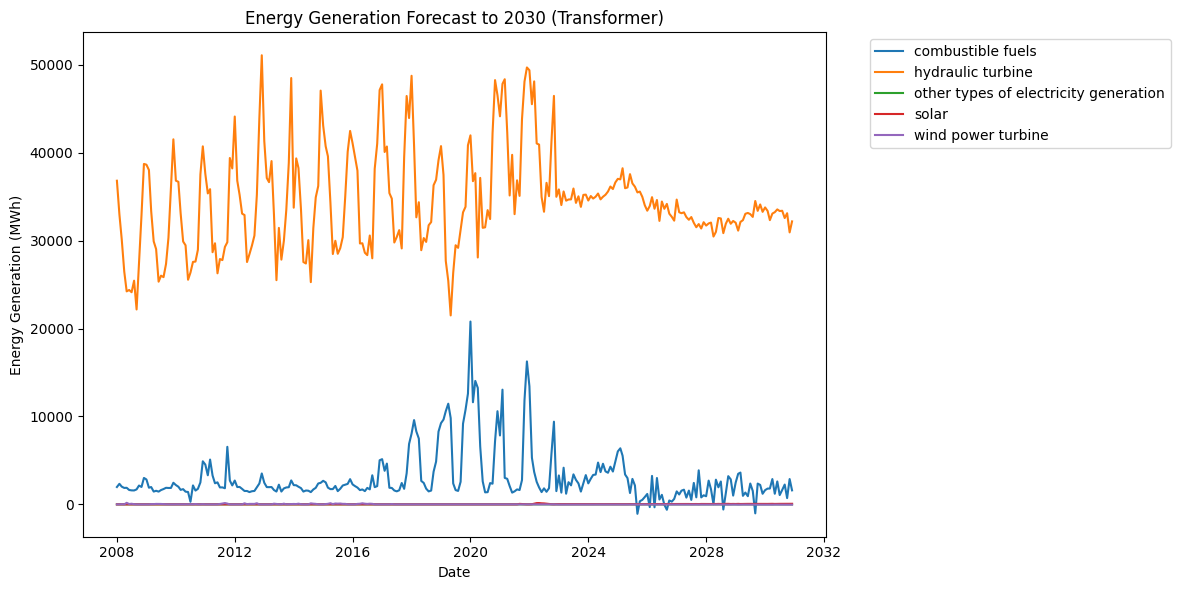

In [39]:
# Combine historical and forecasted data
combined = pd.concat([df_pivot, forecast_df])

# Plot each generation type
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for column in df_pivot.columns:
    plt.plot(combined.index, combined[column], label=column)

plt.title("Energy Generation Forecast to 2030 (Transformer)")
plt.xlabel("Date")
plt.ylabel("Energy Generation (MWh)")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()
